## DIABETES.csv


In [1]:
import pandas as pd
import numpy as np
import requests
import time

from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score
from prefect import flow, task, get_run_logger
from typing import Callable
from functools import wraps
from io import StringIO
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics 
from sklearn.svm import SVC
from sklearn import datasets

# Para representar el árbol de decisión
from six import StringIO  # Capa de compatibilidad entre Python 2 y Python 3
from sklearn.tree import export_graphviz # Visualización de árboles de decisión
from IPython.display import Image # Módulo de gestión de imágenes digitales 
import pydotplus # Envoltorio mejorado del lenguaje "dot" de graphviz 

In [2]:
def timing_decorator(func: Callable) -> Callable:
    '''Custom decorator to time task execution'''
    @wraps(func)
    def wrapper(*args, **kwargs):
        logger = get_run_logger()
        start_time = time.time()

        # Execute the original function
        result = func(*args, **kwargs)

        end_time = time.time()
        execution_time = end_time - start_time

        logger.info(f"Task '{func.__name__}' completed in {execution_time:.2f} seconds")
        return result

    return wrapper

In [3]:
@task
@timing_decorator
def diabetes_dataset_retribution():
        # Se define el nombre de las columnas en una lista 
    nombre_columnas = ['Embarazos', 'Glucosa', 'Presion Arterial', 'Grosor Piel', 'Insulina', 'Indice Masa Corporal', 'Función de Pedigree', 'Edad', 'Etiqueta']

    # Se usa la biblioteca Pandas para cargar el dataset desde un archivo de texto 
    # "separado por comas" (CSV), usando los nombres de columna previamente definidos
    try:
        response = requests.get("https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv")
        response.raise_for_status()
        csv_data = StringIO(response.text)
        dataset = pd.read_csv(csv_data, header=1, names=nombre_columnas)
        print("Dataset cargado exitosamente.")
        print(dataset.head())
        return dataset
    except requests.exceptions.RequestException as e:
        print(f"Error al descargar el dataset: {e}")
        raise e
    except Exception as e:
        print(f"Error al cargar el dataset: {e}")
        raise e


In [4]:
@task
@timing_decorator
def iris_dataset_retribution():
    #Lectura de los datos
    df= pd.read_csv('iris.csv')
 
    # También se puede cargar desde el paquete sklearn.datasets
    #df = load_iris()
 
    # previsualización del dataset
    df.head(5)
 
    return df


In [5]:
@task
@timing_decorator
def cancer_dataset_retribution():
    dataset = datasets.load_breast_cancer()
    print("Características (X_i): ", dataset.feature_names)
 
    return dataset


In [6]:
@task
@timing_decorator
def iris_preprocessing(df):
    X_train, X_test, y_train, y_test = train_test_split(df[['SepalLengthCm', 'SepalWidthCm',
                                                        'PetalLengthCm', 'PetalWidthCm']],
                                                    df['Species'], random_state=0)
 
    print("Tamaño de X_train: {}\nTamaño de y_train: {}".format(X_train.shape, y_train.shape))
    print("Tamaño de X_test: {}\nTamaño de y_test: {}".format(X_test.shape, y_test.shape))
 
    return X_train, X_test, y_train, y_test

In [7]:
@task
@timing_decorator
def diabetes_preprocessing(dataset):
    feature_cols = ['Embarazos', 'Insulina', 'Indice Masa Corporal', 'Edad', 'Glucosa', 'Presion Arterial', 'Función de Pedigree']

    X = dataset[feature_cols] # Características
    y = dataset.Etiqueta # Variable objetivo

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% para entrenamiento
    print("Tamaño de X_train: {}\nTamaño de y_train: {}".format(X_train.shape, y_train.shape)) #Salida con formato en Python
    print("Tamaño de X_test: {}\nTamaño de y_test: {}".format(X_test.shape, y_test.shape))
    return X_train, X_test, y_train, y_test

In [8]:
@task
@timing_decorator
def cancer_preprocessing(dataset):
    X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, test_size=0.3,random_state=109)
 
    print("Tamaño de X_train: {}\nTamaño de y_train: {}".format(X_train.shape, y_train.shape))
    print("Tamaño de X_test: {}\nTamaño de y_test: {}".format(X_test.shape, y_test.shape))
 
    return X_train, X_test, y_train, y_test

In [9]:
@task
@timing_decorator
def decision_tree(X_train, X_test, y_train, y_test):
    dtree = DecisionTreeClassifier()

    # Entrenamiento
    dtree = dtree.fit(X_train,y_train)

    #Predicción para evaluación
    y_pred = dtree.predict(X_test)

    pd.concat([X_test, y_test, pd.Series(y_pred, name='Predicción', index=X_test.index)], 
          ignore_index=False, axis=1)

    cv_scores = cross_val_score(dtree, X_train, y_train, cv=5)

    # Escribe en pantalla los desempeños ("accuracy") para cada "pliegue" (fold)
    print("Resultados de la validación cruzada en decision tree: ", cv_scores)

    # Escribe en pantalla el promedio de la métrica "accuracy" en el entrenamiento 
    print("Resultado promedio de la validación cruzada en decision tree", np.average(cv_scores))

    # Escribe en pantalla la métrica "accuracy" para prueba (datos no usados en el entrenamiento)
    print("Exactitud (accuracy) en prueba (testing) del decision tree:",metrics.accuracy_score(y_test, y_pred))

    fpr,tpr,_r=metrics.roc_curve(y_test,y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    print(roc_auc)
    metrics.RocCurveDisplay.from_estimator(dtree, X_test, y_test)

    return dtree

In [10]:
@task
@timing_decorator
def random_forest(X_train, X_test, y_train, y_test):
    # Create a Random Forest Classifier instance 
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Train the model
    rf_model.fit(X_train, y_train)

    # Make predictions
    rf_predictions = rf_model.predict(X_test)

    # Evaluate the model 
    rf_accuracy = accuracy_score(y_test, rf_predictions) 
    print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

    return rf_model

In [11]:
@task
@timing_decorator
def knn(X_train, X_test, y_train, y_test):
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train, y_train)
 
    y_pred = knn.predict(X_test)
    # comparación de las predicciones con las etiquetas originales
    pd.concat([X_test, y_test, pd.Series(y_pred, name='Predicción', index=X_test.index)],
            ignore_index=False, axis=1)
    print("Score sobre el conjunto de test: {:.3f}".format(knn.score(X_train, y_train)))
 
    np.set_printoptions(precision=2)
    cv_scores = cross_val_score(knn, X_test, y_test, cv=5)
    print (cv_scores)
 
    print("Desempeño promedio del kNN:")
    print(np.average(cv_scores))
 
    print("Exactitud (accuracy) en prueba (testing) del kNN:",metrics.accuracy_score(y_test, y_pred))
  
    return knn


In [12]:
@task
def knn_scaler(X_train, X_test, y_train, y_test):
    scaler = StandardScaler()
    x_train_scaler = scaler.fit_transform(X_train)
    x_test_scaler = scaler.transform(X_test)
 
 
    knn_scaled = KNeighborsClassifier(n_neighbors=1)
    knn_scaled.fit(x_train_scaler, y_train)
 
    y_pred = knn_scaled.predict(x_test_scaler)
 
    comparacion_df = pd.concat([X_test,
                               y_test,
                               pd.Series(y_pred, name='Predicción' , index=X_test.index)],
                              ignore_index=False, axis=1)
    print("Comparación de predicciones:")
    print(comparacion_df.head())
 
    print("Score sobre el conjunto de test: {:.3f}".format(knn_scaled.score(x_test_scaler, y_test)))
 
 
    np.set_printoptions(precision=2)
    cv_scores = cross_val_score(knn_scaled, x_train_scaler, y_train, cv=5)
    print (cv_scores)
 
    print("Desempeno promedio:")
    print(np.average(cv_scores))
 
    print("Exactitud (accuracy) en prueba (testing):",metrics.accuracy_score(y_test, y_pred))
 
    return knn_scaled

In [13]:
@task
@timing_decorator
def svm(X_train, X_test, y_train, y_test):
    svm_class = SVC(kernel='rbf', random_state=0)
    svm_class.fit(X_train, y_train)
 
    y_pred = svm_class.predict(X_test)
 
    resultado_comparacion = pd.concat([X_test, y_test, pd.Series(y_pred, name='Predicción', index=X_test.index)],
            ignore_index=False, axis=1)
    print("Comparación de predicciones:")
    print(resultado_comparacion)
   
    print("Score de entrenamiento: {:.3f}".format(svm_class.score(X_train, y_train)))
    print("Score de test: {:.3f}".format(svm_class.score(X_test, y_test)))
 
    np.set_printoptions(precision=2)
    cv_scores = cross_val_score(svm_class, X_train, y_train, cv=5)
    print("Scores de validación cruzada:")
    print(cv_scores)
 
    print("Desempeño promedio:")
    print(np.average(cv_scores))
 
    print("Accuracy en el testing:", metrics.accuracy_score(y_test, y_pred))

    return svm_class



In [14]:
@task
@timing_decorator
def svm_scaler(X_train, X_test, y_train, y_test):
 
    scaler = StandardScaler()
    x_train_scaler = scaler.fit_transform(X_train)
    x_test_scaler = scaler.transform(X_test)
 
    svm_class_scaled = svm.SVC(kernel='rbf', random_state=0)
    svm_class_scaled.fit(x_train_scaler, y_train)
 
    y_pred = svm_class_scaled.predict(x_test_scaler)
 
    resultado_comparacion = pd.concat([X_test, y_test, pd.Series(y_pred, name='Predicción', index=X_test.index)],
            ignore_index=False, axis=1)
    print("Comparación de predicciones:")
    print(resultado_comparacion)
   
    print("Score de entrenamiento: {:.3f}".format(svm_class_scaled.score(x_train_scaler, y_train)))
    print("Score de test: {:.3f}".format(svm_class_scaled.score(x_test_scaler, y_test)))
 
    np.set_printoptions(precision=2)
    cv_scores = cross_val_score(svm_class_scaled, x_train_scaler, y_train, cv=5)
    print("Scores de validación cruzada:")
    print(cv_scores)
 
    print("Desempeño promedio:")
    print(np.average(cv_scores))
 
    print("Accuracy en el testing:", metrics.accuracy_score(y_test, y_pred))
 
    return svm_class_scaled

In [15]:
@task
@timing_decorator
def confusion_matrix(class_names, model, X_test, y_test):
 
    print("Visualización de desempeño con Matriz de Confusión:")
  
    disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=None
    )
 
    disp.ax_.set_title("Confusion Matrix")
    print("Confusion Matrix")
    print(disp.confusion_matrix)
 
    plt.show()

In [16]:
@flow
def iris_flow():
    df = iris_dataset_retribution()
    X_train, X_test, y_train, y_test = iris_preprocessing(df)
    
    class_names = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
    
    dtree = decision_tree(X_train, X_test, y_train, y_test)
    confusion_matrix(class_names, dtree, X_test, y_test)

    rf =random_forest(X_train, X_test, y_train, y_test)
    confusion_matrix(class_names, rf, X_test, y_test)

    knn = knn(X_train, X_test, y_train, y_test)
    confusion_matrix(class_names, knn, X_test, y_test)
    knn_scaled = knn_scaler(X_train, X_test, y_train, y_test)
    confusion_matrix(class_names, knn_scaled, X_test, y_test)

    svm_class = svm(X_train, X_test, y_train, y_test)
    confusion_matrix(class_names, svm_class, X_test, y_test)
    svm_class_scaled = svm_scaler(X_train, X_test, y_train, y_test)
    confusion_matrix(class_names, svm_class_scaled, X_test, y_test)
iris_flow()

12:22:19.956 | INFO    | prefect - Starting temporary server on http://127.0.0.1:8281
See https://docs.prefect.io/v3/concepts/server#how-to-guides for more information on running a dedicated Prefect server.

12:22:31.105 | INFO    | Flow run 'gleaming-crab' - Beginning flow run 'gleaming-crab' for flow 'iris-flow'

12:22:31.191 | INFO    | Task run 'iris_dataset_retribution-3b8' - Task 'iris_dataset_retribution' completed in 0.01 seconds

12:22:31.205 | INFO    | Task run 'iris_dataset_retribution-3b8' - Finished in state Completed()

Tamaño de X_train: (112, 4)
Tamaño de y_train: (112,)
Tamaño de X_test: (38, 4)
Tamaño de y_test: (38,)


12:22:31.268 | INFO    | Task run 'iris_preprocessing-559' - Task 'iris_preprocessing' completed in 0.00 seconds

12:22:31.280 | INFO    | Task run 'iris_preprocessing-559' - Finished in state Completed()

Resultados de la validación cruzada en decision tree:  [1.         0.95652174 1.         0.90909091 0.95454545]
Resultado promedio de la validación cruzada en decision tree 0.9640316205533598
Exactitud (accuracy) en prueba (testing) del decision tree: 0.9736842105263158


12:22:31.384 | ERROR   | Task run 'decision_tree-e69' - Task run failed with exception: ValueError('multiclass format is not supported')
Traceback (most recent call last):
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\task_engine.py", line 870, in run_context
    yield self
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\task_engine.py", line 1510, in run_task_sync
    engine.call_task_fn(txn)
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\task_engine.py", line 887, in call_task_fn
    result = call_with_parameters(self.task.fn, parameters)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\utilities\callables.py", line 210, in call_with_parameters
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\aleja\AppData\Local\Temp\ipykernel_41676\3613525291.py", line 9, in wrapper
    result = func(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\aleja\AppData\Local\Temp\ipykernel_41676\1765878611.py", line 26, in decision_tree
    fpr,tpr,_r=metrics.roc_curve(y_test,y_pred)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\sklearn\utils\_param_validation.py", line 218, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\sklearn\metrics\_ranking.py", line 1163, in roc_curve
    fps, tps, thresholds = _binary_clf_curve(
                           ^^^^^^^^^^^^^^^^^^
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\sklearn\metrics\_ranking.py", line 863, in _binary_clf_curve
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

12:22:31.415 | ERROR   | Task run 'decision_tree-e69' - Finished in state Failed('Task run encountered an exception ValueError: multiclass format is not supported')

12:22:31.424 | ERROR   | Flow run 'gleaming-crab' - Encountered exception during execution: ValueError('multiclass format is not supported')
Traceback (most recent call last):
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\flow_engine.py", line 781, in run_context
    yield self
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\flow_engine.py", line 1395, in run_flow_sync
    engine.call_flow_fn()
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\flow_engine.py", line 801, in call_flow_fn
    result = call_with_parameters(self.flow.fn, self.parameters)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\utilities\callables.py", line 210, in call_with_parameters
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\aleja\AppData\Local\Temp\ipykernel_41676\3495911945.py", line 8, in iris_flow
    dtree = decision_tree(X_train, X_test, y_train, y_test)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\tasks.py", line 1139, in __call__
    return run_task(
           ^^^^^^^^^
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\task_engine.py", line 1737, in run_task
    return run_task_sync(**kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\task_engine.py", line 1512, in run_task_sync
    return engine.state if return_type == "state" else engine.result()
                                                       ^^^^^^^^^^^^^^^
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\task_engine.py", line 493, in result
    raise self._raised
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\task_engine.py", line 870, in run_context
    yield self
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\task_engine.py", line 1510, in run_task_sync
    engine.call_task_fn(txn)
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\task_engine.py", line 887, in call_task_fn
    result = call_with_parameters(self.task.fn, parameters)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\utilities\callables.py", line 210, in call_with_parameters
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\aleja\AppData\Local\Temp\ipykernel_41676\3613525291.py", line 9, in wrapper
    result = func(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\aleja\AppData\Local\Temp\ipykernel_41676\1765878611.py", line 26, in decision_tree
    fpr,tpr,_r=metrics.roc_curve(y_test,y_pred)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\sklearn\utils\_param_validation.py", line 218, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\sklearn\metrics\_ranking.py", line 1163, in roc_curve
    fps, tps, thresholds = _binary_clf_curve(
                           ^^^^^^^^^^^^^^^^^^
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\sklearn\metrics\_ranking.py", line 863, in _binary_clf_curve
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

12:22:31.483 | INFO    | Flow run 'gleaming-crab' - Finished in state Failed('Flow run encountered an exception: ValueError: multiclass format is not supported')

ValueError: multiclass format is not supported

In [17]:
@flow
def cancer_flow():
    dataset = cancer_dataset_retribution()
    X_train, X_test, y_train, y_test = cancer_preprocessing(dataset)

    class_names = ['0','1']

    dtree = decision_tree(X_train, X_test, y_train, y_test)
    confusion_matrix(class_names, dtree, X_test, y_test)

    rf =random_forest(X_train, X_test, y_train, y_test)
    confusion_matrix(class_names, rf, X_test, y_test)

    knn = knn(X_train, X_test, y_train, y_test)
    confusion_matrix(class_names, knn, X_test, y_test)
    knn_scaled = knn_scaler(X_train, X_test, y_train, y_test)
    confusion_matrix(class_names, knn_scaled, X_test, y_test)

    svm_class = svm(X_train, X_test, y_train, y_test)
    confusion_matrix(class_names, svm_class, X_test, y_test)
    svm_class_scaled = svm_scaler(X_train, X_test, y_train, y_test)
    confusion_matrix(class_names, svm_class_scaled, X_test, y_test)
cancer_flow()

12:23:01.461 | INFO    | Flow run 'auspicious-jackal' - Beginning flow run 'auspicious-jackal' for flow 'cancer-flow'

Características (X_i):  ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


12:23:01.549 | INFO    | Task run 'cancer_dataset_retribution-ebd' - Task 'cancer_dataset_retribution' completed in 0.04 seconds

12:23:01.561 | INFO    | Task run 'cancer_dataset_retribution-ebd' - Finished in state Completed()

Tamaño de X_train: (398, 30)
Tamaño de y_train: (398,)
Tamaño de X_test: (171, 30)
Tamaño de y_test: (171,)


12:23:01.622 | INFO    | Task run 'cancer_preprocessing-8d2' - Task 'cancer_preprocessing' completed in 0.00 seconds

12:23:01.635 | INFO    | Task run 'cancer_preprocessing-8d2' - Finished in state Completed()

12:23:01.705 | ERROR   | Task run 'decision_tree-b0c' - Task run failed with exception: AttributeError("'numpy.ndarray' object has no attribute 'index'")
Traceback (most recent call last):
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\task_engine.py", line 870, in run_context
    yield self
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\task_engine.py", line 1510, in run_task_sync
    engine.call_task_fn(txn)
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\task_engine.py", line 887, in call_task_fn
    result = call_with_parameters(self.task.fn, parameters)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\utilities\callables.py", line 210, in call_with_parameters
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\aleja\AppData\Local\Temp\ipykernel_41676\3613525291.py", line 9, in wrapper
    result = func(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\aleja\AppData\Local\Temp\ipykernel_41676\1765878611.py", line 12, in decision_tree
    pd.concat([X_test, y_test, pd.Series(y_pred, name='Predicción', index=X_test.index)],
                                                                         ^^^^^^^^^^^^
AttributeError: 'numpy.ndarray' object has no attribute 'index'

12:23:01.728 | ERROR   | Task run 'decision_tree-b0c' - Finished in state Failed("Task run encountered an exception AttributeError: 'numpy.ndarray' object has no attribute 'index'")

12:23:01.735 | ERROR   | Flow run 'auspicious-jackal' - Encountered exception during execution: AttributeError("'numpy.ndarray' object has no attribute 'index'")
Traceback (most recent call last):
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\flow_engine.py", line 781, in run_context
    yield self
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\flow_engine.py", line 1395, in run_flow_sync
    engine.call_flow_fn()
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\flow_engine.py", line 801, in call_flow_fn
    result = call_with_parameters(self.flow.fn, self.parameters)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\utilities\callables.py", line 210, in call_with_parameters
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\aleja\AppData\Local\Temp\ipykernel_41676\39496208.py", line 8, in cancer_flow
    dtree = decision_tree(X_train, X_test, y_train, y_test)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\tasks.py", line 1139, in __call__
    return run_task(
           ^^^^^^^^^
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\task_engine.py", line 1737, in run_task
    return run_task_sync(**kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\task_engine.py", line 1512, in run_task_sync
    return engine.state if return_type == "state" else engine.result()
                                                       ^^^^^^^^^^^^^^^
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\task_engine.py", line 493, in result
    raise self._raised
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\task_engine.py", line 870, in run_context
    yield self
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\task_engine.py", line 1510, in run_task_sync
    engine.call_task_fn(txn)
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\task_engine.py", line 887, in call_task_fn
    result = call_with_parameters(self.task.fn, parameters)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\utilities\callables.py", line 210, in call_with_parameters
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\aleja\AppData\Local\Temp\ipykernel_41676\3613525291.py", line 9, in wrapper
    result = func(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\aleja\AppData\Local\Temp\ipykernel_41676\1765878611.py", line 12, in decision_tree
    pd.concat([X_test, y_test, pd.Series(y_pred, name='Predicción', index=X_test.index)],
                                                                         ^^^^^^^^^^^^
AttributeError: 'numpy.ndarray' object has no attribute 'index'

12:23:01.810 | INFO    | Flow run 'auspicious-jackal' - Finished in state Failed("Flow run encountered an exception: AttributeError: 'numpy.ndarray' object has no attribute 'index'")

AttributeError: 'numpy.ndarray' object has no attribute 'index'

12:23:09.002 | INFO    | Flow run 'idealistic-millipede' - Beginning flow run 'idealistic-millipede' for flow 'diabetes-flow'

Dataset cargado exitosamente.
   Embarazos  Glucosa  Presion Arterial  Grosor Piel  Insulina  \
0          1       85                66           29         0   
1          8      183                64            0         0   
2          1       89                66           23        94   
3          0      137                40           35       168   
4          5      116                74            0         0   

   Indice Masa Corporal  Función de Pedigree  Edad  Etiqueta  
0                  26.6                0.351    31         0  
1                  23.3                0.672    32         1  
2                  28.1                0.167    21         0  
3                  43.1                2.288    33         1  
4                  25.6                0.201    30         0  


12:23:09.227 | INFO    | Task run 'diabetes_dataset_retribution-0e2' - Task 'diabetes_dataset_retribution' completed in 0.18 seconds

12:23:09.238 | INFO    | Task run 'diabetes_dataset_retribution-0e2' - Finished in state Completed()

Tamaño de X_train: (536, 7)
Tamaño de y_train: (536,)
Tamaño de X_test: (231, 7)
Tamaño de y_test: (231,)


12:23:09.295 | INFO    | Task run 'diabetes_preprocessing-d30' - Task 'diabetes_preprocessing' completed in 0.00 seconds

12:23:09.311 | INFO    | Task run 'diabetes_preprocessing-d30' - Finished in state Completed()

Resultados de la validación cruzada en decision tree:  [0.73148148 0.71962617 0.6728972  0.71962617 0.69158879]
Resultado promedio de la validación cruzada en decision tree 0.7070439598476981
Exactitud (accuracy) en prueba (testing) del decision tree: 0.7142857142857143
0.6732269810993584


12:23:10.516 | INFO    | Task run 'decision_tree-852' - Task 'decision_tree' completed in 1.15 seconds

12:23:10.530 | INFO    | Task run 'decision_tree-852' - Finished in state Completed()

Visualización de desempeño con Matriz de Confusión:


12:23:10.590 | ERROR   | Task run 'confusion_matrix-3de' - Task run failed with exception: NameError("name 'ConfusionMatrixDisplay' is not defined")
Traceback (most recent call last):
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\task_engine.py", line 870, in run_context
    yield self
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\task_engine.py", line 1510, in run_task_sync
    engine.call_task_fn(txn)
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\task_engine.py", line 887, in call_task_fn
    result = call_with_parameters(self.task.fn, parameters)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\utilities\callables.py", line 210, in call_with_parameters
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\aleja\AppData\Local\Temp\ipykernel_41676\3613525291.py", line 9, in wrapper
    result = func(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\aleja\AppData\Local\Temp\ipykernel_41676\1612211505.py", line 7, in confusion_matrix
    disp = ConfusionMatrixDisplay.from_estimator(
           ^^^^^^^^^^^^^^^^^^^^^^
NameError: name 'ConfusionMatrixDisplay' is not defined

12:23:10.628 | ERROR   | Task run 'confusion_matrix-3de' - Finished in state Failed("Task run encountered an exception NameError: name 'ConfusionMatrixDisplay' is not defined")

12:23:10.631 | ERROR   | Flow run 'idealistic-millipede' - Encountered exception during execution: NameError("name 'ConfusionMatrixDisplay' is not defined")
Traceback (most recent call last):
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\flow_engine.py", line 781, in run_context
    yield self
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\flow_engine.py", line 1395, in run_flow_sync
    engine.call_flow_fn()
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\flow_engine.py", line 801, in call_flow_fn
    result = call_with_parameters(self.flow.fn, self.parameters)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\utilities\callables.py", line 210, in call_with_parameters
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\aleja\AppData\Local\Temp\ipykernel_41676\2286811579.py", line 9, in diabetes_flow
    confusion_matrix(class_names, dtree, X_test, y_test)
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\tasks.py", line 1139, in __call__
    return run_task(
           ^^^^^^^^^
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\task_engine.py", line 1737, in run_task
    return run_task_sync(**kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\task_engine.py", line 1512, in run_task_sync
    return engine.state if return_type == "state" else engine.result()
                                                       ^^^^^^^^^^^^^^^
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\task_engine.py", line 493, in result
    raise self._raised
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\task_engine.py", line 870, in run_context
    yield self
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\task_engine.py", line 1510, in run_task_sync
    engine.call_task_fn(txn)
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\task_engine.py", line 887, in call_task_fn
    result = call_with_parameters(self.task.fn, parameters)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\prefect\utilities\callables.py", line 210, in call_with_parameters
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\aleja\AppData\Local\Temp\ipykernel_41676\3613525291.py", line 9, in wrapper
    result = func(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\aleja\AppData\Local\Temp\ipykernel_41676\1612211505.py", line 7, in confusion_matrix
    disp = ConfusionMatrixDisplay.from_estimator(
           ^^^^^^^^^^^^^^^^^^^^^^
NameError: name 'ConfusionMatrixDisplay' is not defined

12:23:10.689 | INFO    | Flow run 'idealistic-millipede' - Finished in state Failed("Flow run encountered an exception: NameError: name 'ConfusionMatrixDisplay' is not defined")

NameError: name 'ConfusionMatrixDisplay' is not defined

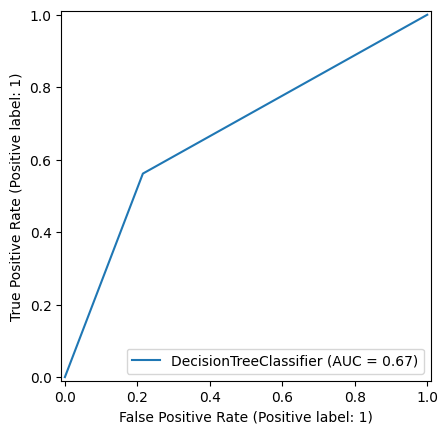

In [18]:
@flow
def diabetes_flow():
    dataset = diabetes_dataset_retribution()
    X_train, X_test, y_train, y_test = diabetes_preprocessing(dataset)

    class_names = ['0','1']

    dtree = decision_tree(X_train, X_test, y_train, y_test)
    confusion_matrix(class_names, dtree, X_test, y_test)

    rf =random_forest(X_train, X_test, y_train, y_test)
    confusion_matrix(class_names, rf, X_test, y_test)

    knn = knn(X_train, X_test, y_train, y_test)
    confusion_matrix(class_names, knn, X_test, y_test)
    knn_scaled = knn_scaler(X_train, X_test, y_train, y_test)
    confusion_matrix(class_names, knn_scaled, X_test, y_test)

    svm_class = svm(X_train, X_test, y_train, y_test)
    confusion_matrix(class_names, svm_class, X_test, y_test)
    svm_class_scaled = svm_scaler(X_train, X_test, y_train, y_test)
    confusion_matrix(class_names, svm_class_scaled, X_test, y_test)
diabetes_flow()